# Irradiance uncertainty - Monte Carlo simulations (FOR CAMS data)

<table>
  <tr>
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/CSTB_logo.jpg" width="200" />
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/Heliocity_logo.png" width="200" /> 
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/USMB_logo_horizontal.png" width="200" />
  </tr>
</table>

<sub>Author: Alexandre MATHIEU, Phd Student, in collaboration Heliocity / CSTB / USMB (LOCIE). </sub>
<sub>Phd thesis: Methodology development to guarantee building photovoltaic systems' performance including failure modelling</sub>


This notebook enables to generate Monte Carlo simulations to generate 95%-interval for the horizontal & Plane Of Array (POA) components.

It corresponds to the section 2.2.2 of Alexandre MATHIEU's PhD manuscript (2025).

The three main uncertainty sources regarding the estimation of the irradiance in the Plane Of Array (POA) for a PV installation come from:

1. The error on the global horizontal irradiance
2. The error on the diffuse and direct components introduced by the decomposition model.
3. The inaccuracy from the transposition model which translates for the horizontal irradiance components into the plane of array.

In [1]:
# Packages..
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import scipy.stats
import seaborn as sns
from global_land_mask import globe

from tqdm import tqdm
from geopandas import GeoDataFrame
from pathlib import Path
from pvlib.irradiance import haydavies, dni, get_extra_radiation
from scipy.stats import gaussian_kde
from shapely.geometry import Point
from shapely import Polygon

# Change the directory path to import functions from local modules
if not 'workbookDir' in globals():
    workbookDir = Path(os.getcwd()).parent
print('Work directory: ' + str(workbookDir))
os.chdir(workbookDir)

# Bunch of local scripts
from pv_uncertainty.config import DATA_PATH, Config
from pv_uncertainty.data.solar_data import bsrn_lat_long_alt, bsrn_name, stations_pv_live, pvlive_lat_long_alt
from pv_uncertainty.utils.helio_fmt import blue, red
from pv_uncertainty.models.optic_model import erbs_simple, erbs_AM # The normal erbs model
from pv_uncertainty.uncertainty.uncertainty_config import euro_stations, START_BSRN, END_BSRN, load_bsrn_data, load_pvlive_data
from pv_uncertainty.uncertainty.study_irradiance import  bestdistfit, get_kd_dist_v2, irrh_scenarios_v4,  transpo_scenarios_v4, collect_quantiles, bar_poster
from pv_uncertainty.publications.pv_uncertainty_2024_poster import collect_quantiles_pv_live 
from pv_uncertainty.publications.pv_uncertainty_2024_article import YEARS,  calculate_kt_kpis, plot_kt_kt, ghi_dhi_bhi_pvgis_2015, image_folder, irr_folder
from pv_uncertainty.utils.helio_fmt import q_plot

data_folder = DATA_PATH / "images" / "irr_uncertainty"

# Get the passwords to access to BSRN dataset
user, password = Config().bsrn()

Work directory: C:\Users\oOo\Desktop\Work\code\pv_uncertainty


# I. Data

## The BSRN dataset

"To train and test the methodology on the horizontal plane, the in-situ measured irradiance
data from BSRN stations [167] have been compared to the satellite CAMS data. The Baseline Surface Radiation Network (BSRN) collects high quality ground-based
radiation measurements of global, direct and diffuse components on the horizontal plane in
2.2 PV performance uncertainties 1-minute resolution with stations over all continents [167]."

In [2]:
# Seperate the BSRN dataset into train and test set
train_index = ['bud',  'cam', 'car','lin', 'pal', 'pay']
test_index = ['cab','cnr',  'tor']

print("Date range for BSRN stations")
print(START_BSRN)
print(END_BSRN)

print("\nTrain/test datasets")
print(train_index)
print(test_index)

Date range for BSRN stations
2005-01-01 00:00:00+01:00
2023-01-01 00:00:00+01:00

Train/test datasets
['bud', 'cam', 'car', 'lin', 'pal', 'pay']
['cab', 'cnr', 'tor']


In [3]:
# Get the metadata of all BSRN stations
df_all = pd.DataFrame()

# If not-predownloaded, it takes approximately 1h-1h30 to download BSRN data
for station in euro_stations:
    lat, lon, alt = bsrn_lat_long_alt(station)
    # Collect meta data
    df_all.loc[station, "city"] = bsrn_name(station)
    df_all.loc[station, ["lat", "long", "alt"]] = lat, lon, alt

print(df_all)
df_all_train = df_all.loc[train_index] # 75 % 
df_all_test = df_all.loc[test_index] # 25 % 

                              city      lat     long    alt
bud                Budapest-Lorinc  47.4291  19.1822  139.1
cab                         Cabauw  51.9711   4.9267    0.0
cam                       Camborne  50.2167  -5.3167   88.0
car                     Carpentras  44.0830   5.0590  100.0
cnr                          Cener  42.8160  -1.6010  471.0
lin                     Lindenberg  52.2100  14.1220  125.0
pal  Palaiseau & SIRTA Observatory  48.7130   2.2080  156.0
pay                        Payerne  46.8123   6.9422  491.0
tor                       Toravere  58.2540  26.4620   70.0


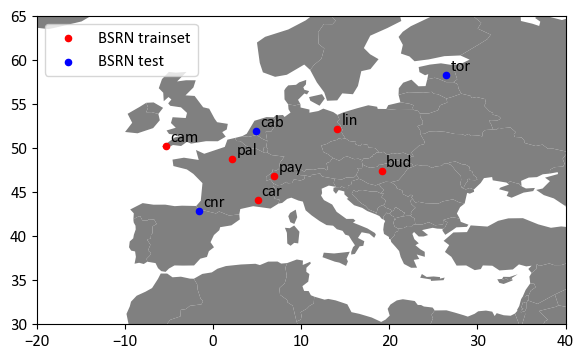

In [4]:
##### Plot the BSRN map ####

# Transform train/test datasets into geopandas object with coordinates
gdf_train = GeoDataFrame(df_all_train, geometry=[Point(xy) for xy in zip(df_all_train['long'], df_all_train['lat'])])
gdf_test = GeoDataFrame(df_all_test, geometry=[Point(xy) for xy in zip(df_all_test['long'], df_all_test['lat'])])

# Load world map
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")

# Plot trainset/test

ax = gdf_train.plot(ax=world.plot(figsize=(6, 4), color="grey"), marker='o', color="red", markersize=20, label="BSRN trainset")
ax = gdf_test.plot(ax=ax, marker='o', color="blue", markersize=20, label="BSRN test")

# Ajudst for Europe
plt.ylim([30, 65])
plt.xlim([-20, 40])

# Add the labels, stored in indexes
for x, y, label in zip(df_all.long, df_all.lat, df_all.index):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    
plt.tight_layout()
plt.legend()

In [5]:
### Collect metrics for satellite vs in-situ for all BSRN datasets
error_m = pd.DataFrame(columns=["ghi", "dhi", "bhi", "dni", "kd", "kt"], index=euro_stations, dtype=float) # Mean error
error_mp = error_m.copy()  # Mean error (relative)
error_std = error_m.copy() # Standard deviation
error_stdp = error_m.copy() # Standard deviation  (relative)
error_rmse = error_m.copy() # Root Mean Square Error
error_p_autocorr = error_m.copy() # Error autocorrelation

for station in tqdm(euro_stations):
    # Get coordinates + data (satelite in weather_df, in_situ in insitu_data...)
    lat, lon, alt = bsrn_lat_long_alt(station) 
    sat_data, insitu_data, solar_position = load_bsrn_data(START_BSRN, END_BSRN, station, user, password, sat_source="cams_pvlib")

    # Filter
    filter = (insitu_data["ghi"] > 0) & (sat_data["ghi"] > 0) & (np.isin(insitu_data.index.year, YEARS[station]))

    # Compute error for each component
    for col in ["ghi", "dhi", "bhi", "dni", "kd", "kt"]:
        error = (insitu_data[col].tz_convert("CET") - sat_data[col].tz_convert("CET")).loc[filter].astype(float)

        error_m.loc[station, col] = error.mean()
        error_mp.loc[station, col] = error.mean() / sat_data.loc[filter, col].mean()
        error_std.loc[station, col] = error.std(ddof=0)
        error_rmse.loc[station, col] = ((error ** 2).mean()) ** (1 / 2)
        error_stdp.loc[station, col] = error.std(ddof=0) / sat_data.loc[filter, col].mean()
        error_p_autocorr.loc[station, col] = error.autocorr()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.04it/s]


In [6]:
print("Kt error metrics")

kt_errors = pd.DataFrame(index=train_index+test_index)
kt_errors["MBE"] = error_m["kt"]
kt_errors["RMSE"] = error_rmse["kt"]
kt_errors["Autocorrelation"] = error_p_autocorr["kt"]

print(kt_errors)
kt_mu =(error_m.loc[train_index, "kt"]**2).mean()**(1/2)
print("\nkt Mean Biais RMSE: " + str(kt_mu.round(4)))
print("kt autocorrelation error: " + str(((error_p_autocorr.loc[train_index, "kt"].mean().round(2)))))

Kt error metrics
          MBE      RMSE  Autocorrelation
bud -0.004005  0.091943         0.234155
cam  0.001823  0.092188         0.315372
car -0.014232  0.079601         0.267922
lin  0.009855  0.091850         0.267732
pal  0.004648  0.086956         0.215049
pay -0.017447  0.101086         0.321406
cab  0.005468  0.087528         0.230210
cnr -0.009194  0.092995         0.253754
tor  0.019467  0.102329         0.304557

kt Mean Biais RMSE: 0.0104
kt autocorrelation error: 0.27


In [7]:
print("Kd error metrics")

kd_errors = pd.DataFrame(index=train_index+test_index)
kd_errors["MBE"] = error_m["kd"]
kd_errors["RMSE"] = error_rmse["kd"]
kd_errors["Autocorrelation"] = error_p_autocorr["kd"]

print(kd_errors)
print("\nkd Mean Biais RMSE: " + str(((error_m.loc[train_index, "kd"] ** 2).mean() ** (1 / 2)).round(4)))
print("kd autocorrelation error: " + str(((error_p_autocorr.loc[train_index, "kd"].mean().round(2)))))

Kd error metrics
          MBE      RMSE  Autocorrelation
bud  0.014444  0.140352         0.411384
cam  0.040070  0.136621         0.479975
car -0.004248  0.129856         0.526224
lin -0.002799  0.132723         0.421785
pal  0.007100  0.130575         0.412065
pay  0.053514  0.162427         0.479324
cab  0.019359  0.132292         0.433545
cnr  0.017338  0.141764         0.451715
tor -0.040746  0.148592         0.418112

kd Mean Biais RMSE: 0.0281
kd autocorrelation error: 0.46


"On the other hand, the PV live irradiance measurement network [168] is comprised of 40
measurement stations in south Germany. Those stations are equipped with class-A SMP10
thermopile pyranometer which measures GHI, and three Si sensors for the POA irradiance.
The three Si sensors are oriented towards east (90°), south (180°) and west (270°) with a tilt angle of 25°.
All stations are located within the latitudes [47.6,49.6] and longitudes
[7.6,10.8]. The data has a 1-minute granularity and ranges from 2019 to 2022."

# II. Residual analysis

## II.1. Clearness index residual study

This section highlights that the error standard deviation on the kt estimation (clearness index) varies with the estimated $kt^{ref}$ from satellite data.  

The kt error standard deviation for each 5%-bin of the satellite $kt^{ref}$ ([0,0.05]...[0.95,1]) is calculated for
all stations in the trainset. The two plots below show those values when the sun elevation is under 15°(left) and over 15°(right).

In [8]:
##### Plot the kt-error as function of satellite clearness index (kt^ref)
sat_source = "cams_pvlib"
std_kt_kt_less15, std_kt_kt_over15 = calculate_kt_kpis(euro_stations, START_BSRN, END_BSRN, user, password,
                                                       sat_source=sat_source)

# Seperate into training and test datasets
std_kt_kt_train = std_kt_kt_less15.loc[:, train_index]
std_kt_kt_test = std_kt_kt_less15.loc[:, test_index]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.01it/s]


[ 0.2484 -0.1098 -1.297   2.6225 -1.5656]


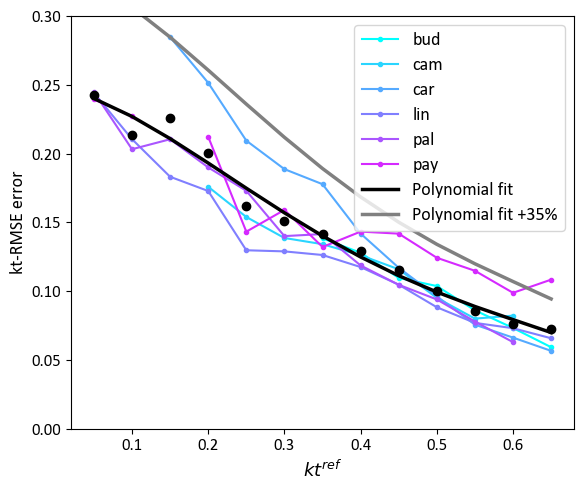

In [9]:
# Plot kt error as function kt^ref for the sun elevation under 15°
params_kt_less15 = plot_kt_kt( std_kt_kt_less15.loc[:, train_index], fontsize=13)
print(np.array(params_kt_less15).round(4))
plt.savefig(image_folder / f"kt_kt_less15_{sat_source}.png")

[ 0.1819 -1.3449  5.8941 -9.335   4.7071]


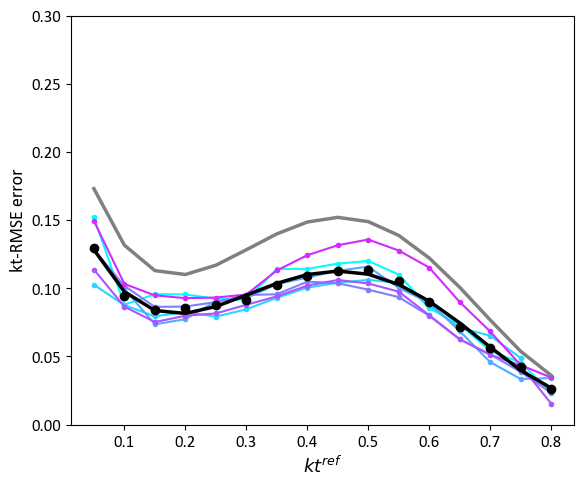

In [10]:
# Plot kt error as function kt^ref for the sun elevation over 15°
params_kt_over15 = plot_kt_kt(std_kt_kt_over15.loc[:, train_index], fontsize=13, legend=False)
print(np.array(params_kt_over15).round(4))
plt.savefig(image_folder / f"kt_kt_over15_{sat_source}.png")

"Intermediate clearness levels between 0.4-0.6 get a significant standard deviation over
all stations in both sun elevation cases due to transient cloud and irradiance levels which
are difficult to apprehend from satellite data. Then, high level of clearness level drastically
decreases the error standard deviation in both cases since those usually represent more stable
periods with higher irradiance levels which are easier to estimate."

"The satellite data are generally less accurate when the sun elevation is lower than 15° in
comparison to over 15°. Also, for the sun elevation less than 15°, there is a higher degree of
inaccuracy with lower clearness levels due to very low light irradiance conditions. However,
with a sun elevation over 15°, a low clearness level gets a lower error on kt since those rather represent very stable cloudy conditions."

## II.2. Diffuse ratio residual distribution

This graph shows how the actual diffuse fraction $kd$ (blue dots) differ compared to the Erbs model which takes the satellite clearness index $kt^{ref}$.

"It was observed that the kd residuals are function of the satellite clearness index $kt^{ref}$.
The Budapest station "bud" has been taken as example and the diffuse fraction as function of
the clearness index is plotted below. The light blue line corresponds to the
Erbs’ model fed with $kt^{ref}$ while, the blue dots are the kd in-situ measurements. The error
interval width (in grey) around the Erbs’ model significantly varies as function of the level of
ktre f with a larger error for intermediate clearness levels (0.4-0.6) and narrower intervals for
low and high clearness indices. The distributions are also more skewed at the limits, around
0 and 1."

In [11]:
station ="bud" # BSRN station

# Get kt/kd data when ghi>0
sat_data, insitu_data, solar_position = load_bsrn_data(START_BSRN, END_BSRN, station, user, password, sat_source="cams_pvlib")
filter = (insitu_data["ghi"] > 0) & (sat_data["ghi"] > 0) & (np.isin(insitu_data.index.year, YEARS[station]))

insitu_data = insitu_data.loc[filter]
sat_data = sat_data.loc[filter]
solar_position = solar_position.loc[filter]

# Prep data
insitu_data["$kt^{ref}$"] = sat_data["kt"]
insitu_data["kd"] = insitu_data["kd"].clip(upper=1) # Over 1 is not realistic

insitu_data = insitu_data.copy()

# Compute the quantiles per 5% interval
insitu_data["kt_sat"] = (insitu_data["$kt^{ref}$"].astype(float) * 20).round(0) / 20 # Round values to make intervals
q05 = insitu_data.astype(float).pivot_table(index="kt_sat", values="kd", aggfunc=lambda x: np.quantile(x, 0.05))["kd"]
q95 = insitu_data.pivot_table(index="kt_sat", values="kd", aggfunc=lambda x: np.quantile(x, 0.95))["kd"]
q75 = insitu_data.pivot_table(index="kt_sat", values="kd", aggfunc=lambda x: np.quantile(x, 0.75))["kd"]
q25 = insitu_data.pivot_table(index="kt_sat", values="kd", aggfunc=lambda x: np.quantile(x, 0.25))["kd"]

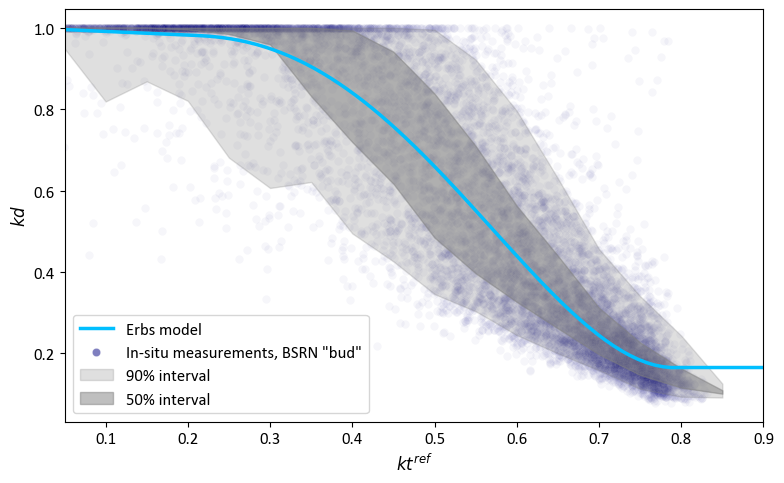

In [12]:
_ = plt.figure(figsize=(8, 5))
# Scatter plot
ax = sns.scatterplot(data=insitu_data, x="$kt^{ref}$", y="kd", color="navy", alpha=0.035,
                     label=f'In-situ measurements, BSRN "{station}"')

# Erbs model curve
kt_erbs = np.linspace(0, 1, 100)
kd_erbs = erbs_simple(kt_erbs)
plt.plot(kt_erbs, kd_erbs, color="deepskyblue", linewidth=2.5, label='Erbs model')

# Quantile intervals in grey
plt.fill_between(q05.index, q05, q95, color="grey", alpha=0.25, label="90% interval")
plt.fill_between(q25.index, q25, q75, color="grey", alpha=0.50, label="50% interval")

plt.ylabel("$kd$")
plt.xlabel("$kt^{ref}$")
plt.xlim([0.05, 0.9])
plt.legend()

leg = ax.get_legend()
leg.legendHandles[1].set_alpha(0.5)
plt.tight_layout()
plt.savefig(image_folder / f"{station}_all_quantiles.png")

## II.3. $kd$ distribution as function of $kt^{ref}$ bin


Estimate the kd-error distributions for each 0.05 kt-interval: 100%|█████████████████████| 3/3 [00:28<00:00,  9.59s/it]
Estimate the kd-error distributions for each 0.05 kt-interval: 100%|█████████████████████| 3/3 [00:26<00:00,  8.91s/it]


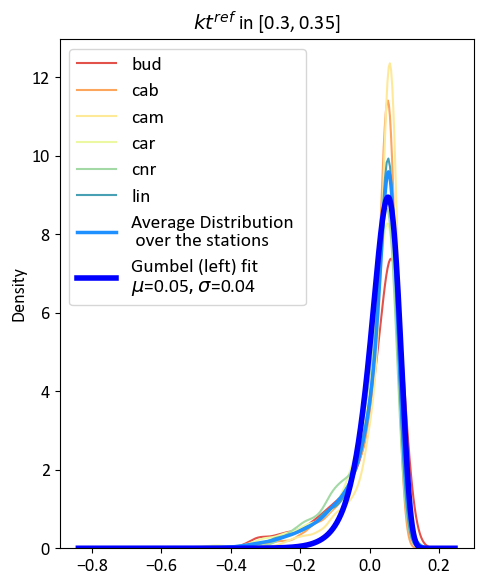

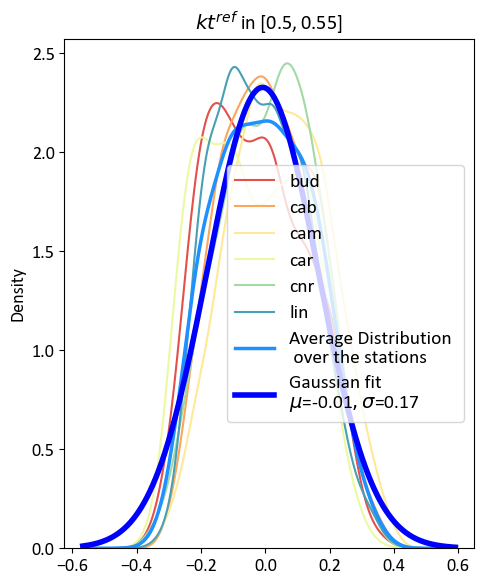

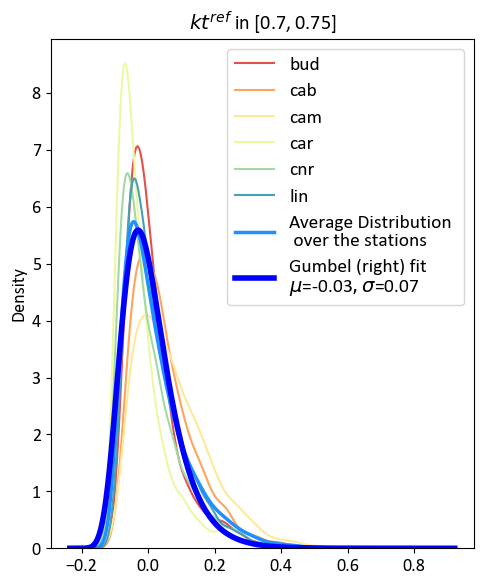

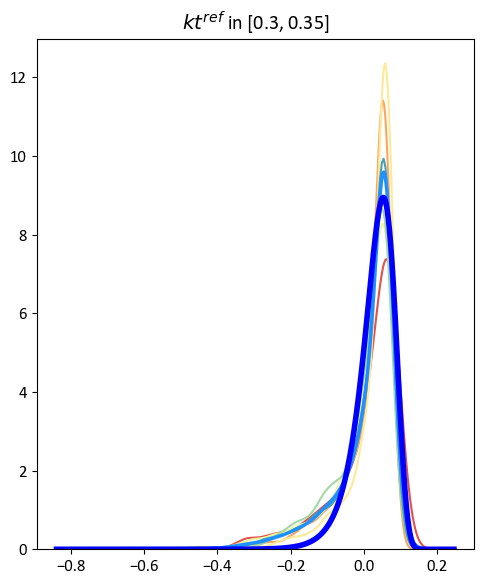

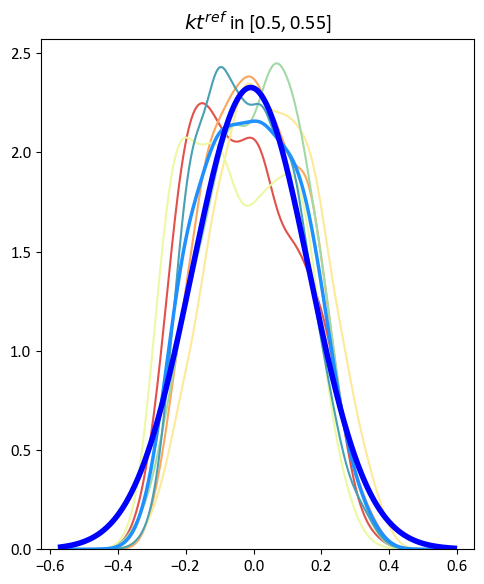

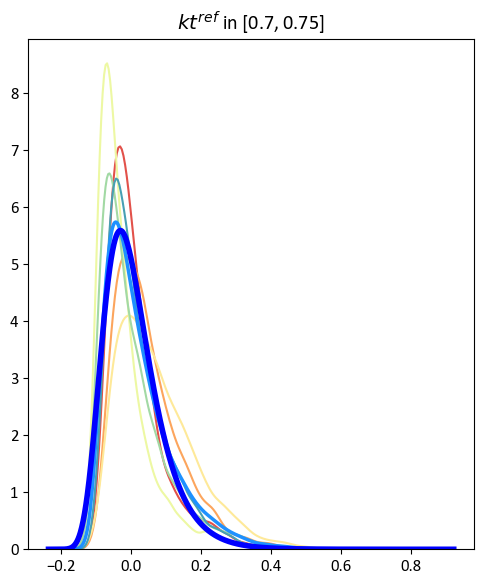

In [13]:
kt_range = [0.3, 0.5, 0.7]
_ = get_kd_dist_v2(overwrite=True, plot_bool=True, kt_range=kt_range, sat_source="cams_pvlib")
_ = get_kd_dist_v2(overwrite=True, plot_bool=True, kt_range=kt_range, sat_source="cams_pvlib", legend=False)

In [14]:
kd_dist = get_kd_dist_v2(train_index=train_index, plot_bool=False, legend=False)
kd_dist.dropna(axis=1)

,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80
#,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0
dist,norm,gumbel_r,norm,norm,gumbel_l,gumbel_l,gumbel_l,gumbel_l,gumbel_l,norm,gumbel_r,gumbel_r,gumbel_r,gumbel_r,gumbel_r,gumbel_r
loc,0.006741,0.009177,0.015505,0.019302,0.033696,0.052597,0.067023,0.066576,0.056347,-0.008783,-0.071516,-0.054561,-0.034982,-0.030268,-0.047017,0.03438
scale,0.008411,0.009046,0.010039,0.013438,0.021292,0.041125,0.076283,0.114745,0.142291,0.171358,0.148714,0.123345,0.096954,0.065834,0.047986,0.114805


"The fitted distributions for each interval Ikt ([0,0.5], [0.05,0.1]....[0.8,0.85]) are computed and can be shown above. Overall, except few exceptions,
Gumbel distributions are adopted to reflect the skewnesses with a transition between
left and right Gumbel distributions at 0.5 where the distribution is Gaussian. Then, the “scale”
parameter, reflecting the distribution width, is the highest within [0.35,0.4]−[0.65,0.7]
which illustrate the uncertainty with transient cloudy-skies."

## II.4. Horizontal Irradiance Validation

Setting widening parameters for kt/kd processes were manually varied until 95% of the values were comprised in the 95%-interval. δkt has then been defined to +35% for kt and +30% for kd.

"The actual stations’ residual distribution is different compared to
the average distribution applied initially. For that purpose, another step recalibrates and
enlarges the error to make sure that 95% of the values are included in the 95% interval on the
training set." (for kt and kd) with the 'factor_kt' and 'factor_kd'

In [15]:
##### Calibration-Validation for factors kt and kd ########
n_scenarios = 1000
factor_kt = 1.35
factor_kd = 1.3

df_25 = pd.DataFrame(index=train_index + test_index, columns=['ghi'])
df_75 = pd.DataFrame(index=train_index + test_index, columns=['ghi'])

# Quantile recipients
if os.path.exists(irr_folder / "df_50_ghi.pkl"):
    df_50 = pd.read_pickle(irr_folder / "df_50_ghi.pkl")
    df_95 = pd.read_pickle(irr_folder / "df_95_ghi.pkl")
    q_kt = pd.read_pickle(irr_folder / "q_kt.pkl")
    q_dhi = pd.read_pickle(irr_folder / "q_dhi.pkl")
    q_bhi = pd.read_pickle(irr_folder / "q_bhi.pkl")
else:
    df_50 = pd.DataFrame(index=train_index + test_index, columns=['ghi'])
    df_95 = pd.DataFrame(index=train_index + test_index, columns=['ghi'])
    q_kt = pd.DataFrame(dtype=float)
    q_dhi = pd.DataFrame(dtype=float)
    q_bhi = pd.DataFrame(dtype=float)

stations_left = df_50[~df_50.index.isin(df_50["ghi"].dropna().index)].index

# Generate the scenarios for horizontal irradiance
for station in stations_left:
    # Load data
    lat, long, alt = bsrn_lat_long_alt(station)
    sat_data, insitu_data, solar_position = load_bsrn_data(START_BSRN, END_BSRN, station, user, password, sat_source="cams_pvlib")
    
    # Keep the periods (including nights) containing the filter
    filter = (insitu_data["ghi"] > 0) & (sat_data["ghi"] > 0) & (np.isin(insitu_data.index.year, YEARS[station]))
    start_filter = filter[filter].index[0]
    end_filter = filter[filter].index[-1]
    sat_data = sat_data.loc[(sat_data.index > start_filter) & (sat_data.index < end_filter)]
    insitu_data = insitu_data.loc[(insitu_data.index > start_filter) & (insitu_data.index < end_filter)]
    solar_position = solar_position.loc[(solar_position.index > start_filter) & (solar_position.index < end_filter)]
    
    # Generate Monte Carlo simulations
    ghi_scns, dhi_scns, bhi_scns = irrh_scenarios_v4(lat, long, alt,
                                                     solar_position, sat_data["ghi"],
                                                     factor_kt=factor_kt,
                                                     factor_kd=factor_kd,
                                                     kt_mu=kt_mu,
                                                     params_kt_less15=params_kt_less15,
                                                     params_kt_over15=params_kt_over15,
                                                     sat_source="cams_pvlib",
                                                     n_scenarios=n_scenarios)

    # Compute the quantiles on filter and collect them
    quantiles_g = ghi_scns.loc[filter].quantile([0.025, 0.125, 0.25, 0.375, 0.625, 0.75, 0.875, 0.975], axis=1).T
    quantiles_b = bhi_scns.loc[filter].quantile([0.025, 0.125, 0.25, 0.375, 0.625, 0.75, 0.875, 0.975], axis=1).T
    quantiles_d = dhi_scns.loc[filter].quantile([0.025, 0.125, 0.25, 0.375, 0.625, 0.75, 0.875, 0.975], axis=1).T
    df_25, df_50, df_75, df_95, q_kt, q_dhi, q_bhi = \
        collect_quantiles(df_25, df_50, df_75, df_95, quantiles_g, quantiles_d, quantiles_b,
                          insitu_data, filter, station, q_kt, q_dhi, q_bhi, ghi_scns, dhi_scns, bhi_scns)

    df_50.to_pickle(irr_folder / "df_50_ghi.pkl")
    df_95.to_pickle(irr_folder / "df_95_ghi.pkl")
    q_kt.to_pickle(irr_folder / "q_kt.pkl")
    q_dhi.to_pickle(irr_folder / "q_dhi.pkl")
    q_bhi.to_pickle(irr_folder / "q_bhi.pkl")

In [16]:
print(df_95)

          ghi    s    e    w       dhi       bhi
bud  0.961503  NaN  NaN  NaN  0.973482  0.962936
cam  0.974065  NaN  NaN  NaN  0.955949  0.981885
car  0.965876  NaN  NaN  NaN  0.987678  0.953805
lin  0.976136  NaN  NaN  NaN  0.971125  0.979918
pal  0.972308  NaN  NaN  NaN  0.976039  0.974947
pay  0.951083  NaN  NaN  NaN  0.967487  0.962404
cab  0.977082  NaN  NaN  NaN  0.968439  0.980911
cnr  0.953617  NaN  NaN  NaN  0.977542  0.958044
tor   0.97308  NaN  NaN  NaN  0.967691  0.975123


#### Quantile evaluation for Horizontal irradiance

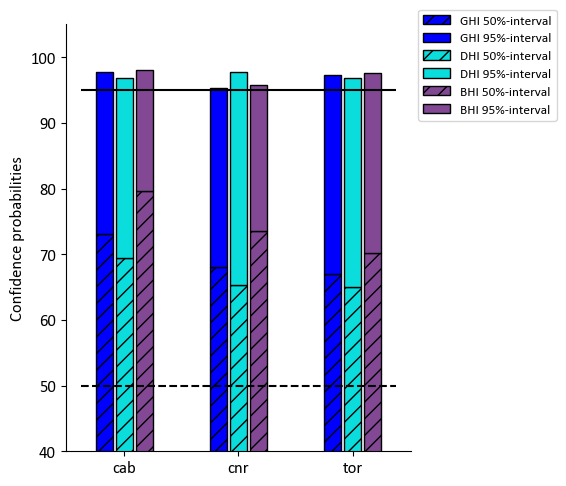

In [17]:
_ = bar_poster(df_50, df_95, test_index)
plt.legend(fontsize=9.5, bbox_to_anchor=(1.0, 1.05))
plt.savefig(image_folder / "irrh_validation.png")

Each data point correspond to the % of the time where the the actual timeserie is under the theoretical quantile
ie, for x = 20%, if y=10%, it means that the actual timeserie is 'only' 10% of the time under the 20% quantile (instead of 20%)
It is then conservative


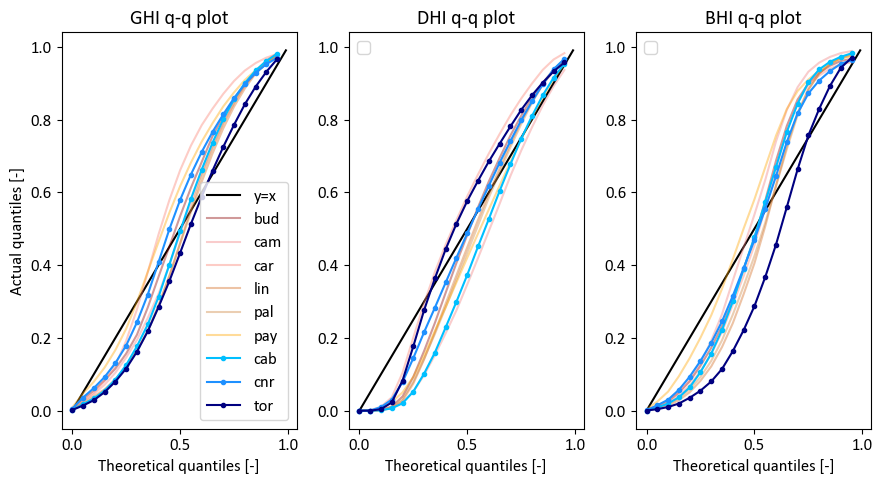

In [18]:
 # qqplot
colors_train = ["darkred", "lightcoral", "salmon", "chocolate", "peru", "orange"]
colors_test = ["deepskyblue", "dodgerblue", "navy"]

print("Each data point correspond to the % of the time where the the actual timeserie is under the theoretical quantile")
print("ie, for x = 20%, if y=10%, it means that the actual timeserie is 'only' 10% of the time under the 20% quantile (instead of 20%)")
print("It is then conservative")

fig, axes = plt.subplots(1, 3, figsize=(9, 5))
axes[0].set_title("GHI q-q plot")
axes[0].plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), color="black", label="y=x")
q_kt.loc[:, train_index].plot(color=colors_train, ax=axes[0], alpha=0.4)
q_kt.loc[:, test_index].plot(color=colors_test, ax=axes[0], marker=".")
axes[0].legend()
axes[0].set_ylabel("Actual quantiles [-]")
axes[0].set_xlabel("Theoretical quantiles [-]")

axes[1].set_title("DHI q-q plot")
axes[1].plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), color="black")
q_dhi.loc[:, train_index].plot(color=colors_train, ax=axes[1], alpha=0.4)
q_dhi.loc[:, test_index].plot(color=colors_test, ax=axes[1], marker=".")
axes[1].legend([])
axes[1].set_xlabel("Theoretical quantiles [-]")

axes[2].set_title("BHI q-q plot")
axes[2].plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), color="black", label="y=x")
q_bhi.loc[:, train_index].plot(color=colors_train, ax=axes[2], alpha=0.4)
q_bhi.loc[:, test_index].plot(color=colors_test, ax=axes[2], marker=".")
axes[2].legend([])
axes[2].set_xlabel("Theoretical quantiles [-]")

plt.tight_layout()

In [19]:
print(df_50)
print(df_95)

          ghi    s    e    w       dhi       bhi
bud  0.697655  NaN  NaN  NaN  0.717313  0.775776
cam    0.6994  NaN  NaN  NaN  0.662062  0.800860
car  0.713756  NaN  NaN  NaN  0.656580  0.786732
lin  0.715283  NaN  NaN  NaN  0.720615  0.801282
pal  0.724714  NaN  NaN  NaN  0.708171  0.789314
pay  0.649484  NaN  NaN  NaN  0.652913  0.709426
cab  0.730286  NaN  NaN  NaN  0.694915  0.796543
cnr  0.679937  NaN  NaN  NaN  0.653867  0.734874
tor  0.669872  NaN  NaN  NaN  0.649420  0.701302
          ghi    s    e    w       dhi       bhi
bud  0.961503  NaN  NaN  NaN  0.973482  0.962936
cam  0.974065  NaN  NaN  NaN  0.955949  0.981885
car  0.965876  NaN  NaN  NaN  0.987678  0.953805
lin  0.976136  NaN  NaN  NaN  0.971125  0.979918
pal  0.972308  NaN  NaN  NaN  0.976039  0.974947
pay  0.951083  NaN  NaN  NaN  0.967487  0.962404
cab  0.977082  NaN  NaN  NaN  0.968439  0.980911
cnr  0.953617  NaN  NaN  NaN  0.977542  0.958044
tor   0.97308  NaN  NaN  NaN  0.967691  0.975123


## II. 5. POA-irradiance validation

In [20]:
######### PV-live  test
stations = stations_pv_live()

n_scenarios = 1000
tilt = 25

n_data = pd.Series(dtype=float)

if os.path.exists(irr_folder / "df_50_poa.pkl"):
    df_50 = pd.read_pickle(irr_folder / "df_50_poa.pkl")
    df_95 = pd.read_pickle(irr_folder / "df_95_poa.pkl")
else:
    df_50 = pd.DataFrame(index=stations.index, columns=['ghi', 's', 'e', 'w'])
    df_95 = pd.DataFrame(index=stations.index, columns=['ghi', 's', 'e', 'w'])

stations_left = df_50[~df_50.index.isin(df_50.dropna().index)].index
print(stations_left)

for station in list(stations_left):
    print(station)
    lat, long, alt = pvlive_lat_long_alt(station)
    sat_data, insitu_h, insitu_s, insitu_e, insitu_w, solar_position = load_pvlive_data(station=station, sat_source="cams_pvlib")

    # Generate Monte Carlo simulations
    ghi_scns, dhi_scns, bhi_scns = irrh_scenarios_v4(lat, long, alt,
                                                     solar_position, sat_data["ghi"],
                                                     factor_kt=factor_kt,
                                                     factor_kd=factor_kd,
                                                     kt_mu=kt_mu,
                                                     params_kt_less15=params_kt_less15,
                                                     params_kt_over15=params_kt_over15,
                                                     sat_source="cams_pvlib",
                                                     n_scenarios=n_scenarios)

    poa_scns_s, _, _, _ = \
        transpo_scenarios_v4(tilt, 180, lat, long, alt, solar_position, ghi_scns, dhi_scns, n_scenarios=n_scenarios)
    poa_scns_e, _, _, _ = \
        transpo_scenarios_v4(tilt, 90, lat, long, alt, solar_position, ghi_scns, dhi_scns, n_scenarios=n_scenarios)

    poa_scns_w, _, _, _ = \
        transpo_scenarios_v4(tilt, 270, lat, long, alt, solar_position, ghi_scns, dhi_scns, n_scenarios=n_scenarios)

    filter = (sat_data["ghi"] > 0) & (insitu_h["Gg_pyr"].reindex(sat_data.index).fillna(0) > 0)
    filter_s = (sat_data["ghi"] > 0) & (insitu_s["Gg_pyr"].reindex(sat_data.index).fillna(0) > 0)
    filter_e = (sat_data["ghi"] > 0) & (insitu_e["Gg_pyr"].reindex(sat_data.index).fillna(0) > 0)
    filter_w = (sat_data["ghi"] > 0) & (insitu_w["Gg_pyr"].reindex(sat_data.index).fillna(0) > 0)

    quantiles_g = ghi_scns.quantile([0.025, 0.25, 0.5, 0.75, 0.975], axis=1).T.loc[filter]
    quantiles_s = poa_scns_s.quantile([0.025, 0.25, 0.75, 0.975], axis=1).T.loc[filter_s]
    quantiles_e = poa_scns_e.quantile([0.025, 0.25, 0.75, 0.975], axis=1).T.loc[filter_e]
    quantiles_w = poa_scns_w.quantile([0.025, 0.25, 0.5, 0.75, 0.975], axis=1).T.loc[filter_w]

    df_50, df_95 = collect_quantiles_pv_live(station, df_50, df_95,
                                             quantiles_g, quantiles_s, quantiles_e, quantiles_w,
                                             insitu_h["Gg_pyr"].loc[filter],
                                             insitu_s["Gg_si_south"].loc[filter_s],
                                             insitu_e["Gg_si_east"].loc[filter_e],
                                             insitu_w["Gg_si_west"].loc[filter_w])
    
    df_50.to_pickle(irr_folder / "df_50_poa.pkl")
    df_95.to_pickle(irr_folder / "df_95_poa.pkl")

Int64Index([], dtype='int64', name='ID')


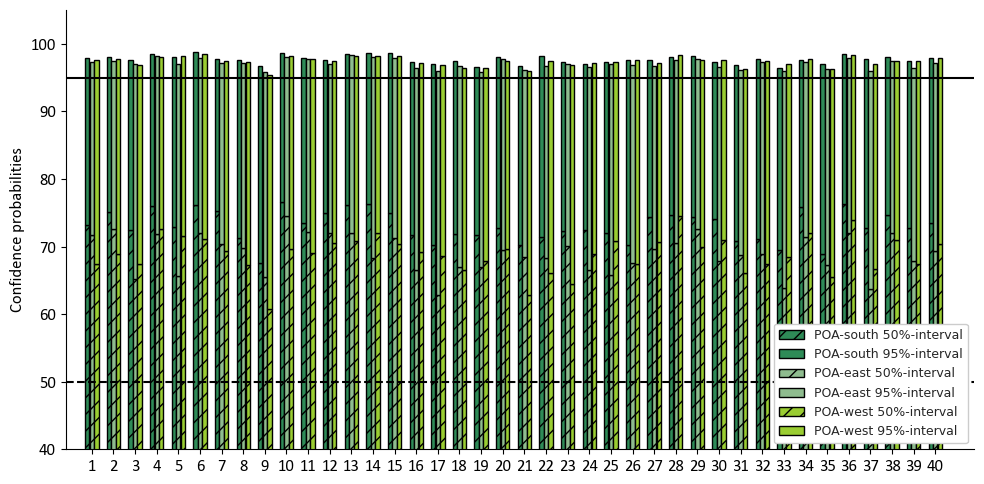

In [21]:
df_50 = pd.read_pickle(irr_folder / "df_50_poa.pkl")
df_95 = pd.read_pickle(irr_folder / "df_95_poa.pkl")

_ = bar_poster(df_50, df_95, df_95.index, poa=True, figsize=(10,5))
plt.tight_layout()
plt.savefig(image_folder / "poa_validation.png")

# III. Illustrations

## III.1. Horizontal plane illustrations

In [22]:
station = "pal"
start_2 = pd.to_datetime("20220812").tz_localize("CET")
end_2 = pd.to_datetime("20220816").tz_localize("CET")

# Get the satellite/in-situ data and narrow them down to a specific date range
sat_data, insitu_data, solar_position = load_bsrn_data(START_BSRN, END_BSRN, station, user, password, sat_source="cams_pvlib")
sat_data = sat_data.loc[start_2: end_2].copy()
insitu_data = insitu_data.loc[start_2: end_2].copy()
solar_position = solar_position.loc[start_2: end_2].copy()

# Compute the MC simulations
n_scenarios = 1000
lat, long, alt = bsrn_lat_long_alt(station)
ghi_scns, dhi_scns, bhi_scns = irrh_scenarios_v4(lat, long, alt,
                                                 solar_position, sat_data["ghi"],
                                                 kt_mu=kt_mu,
                                                 params_kt_less15=params_kt_less15,
                                                 params_kt_over15=params_kt_over15,
                                                 factor_kt=factor_kt, factor_kd=1.3,
                                                 sat_source="cams_pvlib",
                                                 n_scenarios=n_scenarios)

Horizontal Irradiation scenarios: 100%|████████████████████████████████████████████| 1000/1000 [02:36<00:00,  6.40it/s]


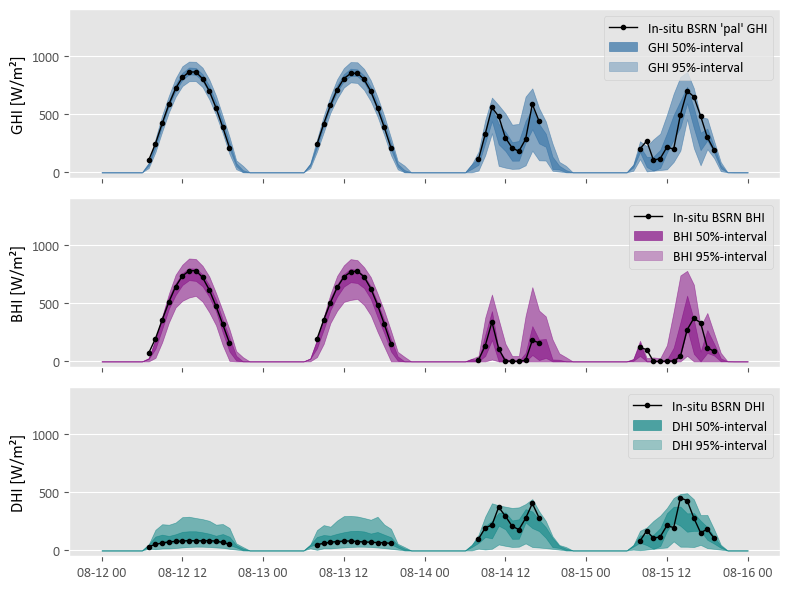

In [23]:
# GHI, BHI, DHI, POAgrd
plt.style.use("ggplot")
quantiles = [0.5, 0.95]
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# GHI
axes[0].plot(insitu_data.loc[:, "ghi"].index, insitu_data.loc[:, "ghi"], color="black", marker=".",
             label=f"In-situ BSRN '{station}' GHI", linewidth=1)
axes[0] = q_plot(ghi_scns.loc[:], quantiles=quantiles, color=blue, ax=axes[0], label="GHI", tweak=True)
alpha = 1 / len(quantiles)
axes[0].set_ylabel("GHI [W/m²]", color="black")
axes[0].set_ylim([-50, 1400])
axes[0].get_xaxis().set_ticks([])
axes[0].get_yaxis().set_ticks([0, 500, 1000])
axes[0].grid(axis="x")

# BHI
axes[1].plot(insitu_data.loc[:, "bhi"].index, insitu_data.loc[:, "bhi"], color="black", marker=".",
             label="In-situ BSRN BHI", linewidth=1)
axes[1] = q_plot(bhi_scns.loc[:], quantiles=quantiles, color="purple", ax=axes[1], label="BHI", tweak=True)
axes[1].set_ylabel("BHI [W/m²]", color="black")
axes[1].set_ylim([-50, 1400])
axes[1].get_xaxis().set_ticks([])
axes[1].get_yaxis().set_ticks([0, 500, 1000])
axes[1].grid(axis="x")

# DHI
axes[2].plot(insitu_data.loc[:, "dhi"].index, insitu_data.loc[:, "dhi"], color="black", marker=".",
             label="In-situ BSRN DHI", linewidth=1)
axes[2] = q_plot(dhi_scns.loc[:], quantiles=quantiles, color="teal", ax=axes[2], label="DHI", tweak=True)

axes[2].set_ylabel("DHI [W/m²]", color="black")
axes[2].set_ylim([-50, 1400])
axes[2].get_yaxis().set_ticks([0, 500, 1000])
axes[2].grid(axis="x")

plt.tight_layout()
plt.savefig(image_folder / f"{station}_h_all_quantiles.png")

## III.2 POA illustrations

In [24]:
stations = stations_pv_live()
tilt = 25
station = 1
start = pd.to_datetime("20220622").tz_localize("CET")
end = pd.to_datetime("20220626").tz_localize("CET")

lat, long, alt = pvlive_lat_long_alt(station)
sat_data, insitu_h, insitu_s, insitu_e, insitu_w, solar_position = load_pvlive_data(start, end, station, sat_source="cams_pvlib")

# Generate Monte Carlo simulations
ghi_scns, dhi_scns, bhi_scns = irrh_scenarios_v4(lat, long, alt,
                                                 solar_position, sat_data["ghi"],
                                                 factor_kt=factor_kt,
                                                 factor_kd=factor_kd,
                                                 kt_mu=kt_mu,
                                                 params_kt_less15=params_kt_less15,
                                                 params_kt_over15=params_kt_over15,
                                                 sat_source="cams_pvlib",
                                                 n_scenarios=n_scenarios)

poa_scns_s, _, _, _ = \
    transpo_scenarios_v4(tilt, 180, lat, long, alt, solar_position, ghi_scns, dhi_scns, n_scenarios=n_scenarios)
poa_scns_e, _, _, _ = \
    transpo_scenarios_v4(tilt, 90, lat, long, alt, solar_position, ghi_scns, dhi_scns, n_scenarios=n_scenarios)

poa_scns_w, _, _, _ = \
    transpo_scenarios_v4(tilt, 270, lat, long, alt, solar_position, ghi_scns, dhi_scns, n_scenarios=n_scenarios)

POA Irradiance simulations: 100%|██████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.98it/s]


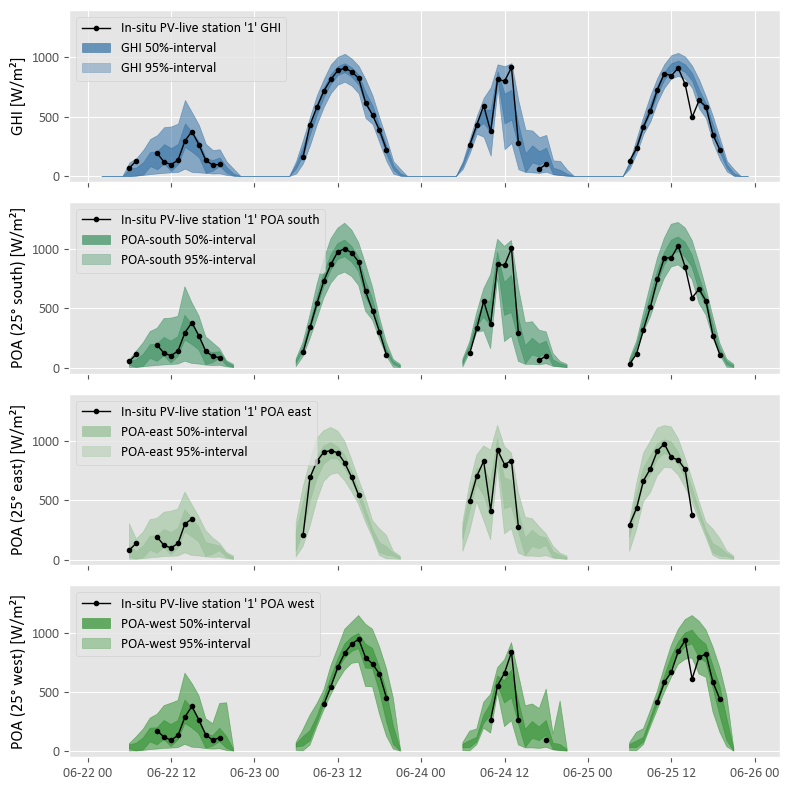

In [25]:
# GHI, POAgrd
quantiles = [0.5, 0.95]
fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True, sharey=True)

# GHI
h_plot = insitu_h.loc[:, "Gg_pyr"].reindex(ghi_scns.index)
h_plot.loc[sat_data["ghi"] <= 0] = np.nan
axes[0].plot(h_plot.index, h_plot, color="black", marker=".", label=f"In-situ PV-live station '{station}' GHI",
             linewidth=1)
axes[0] = q_plot(ghi_scns.loc[:], quantiles=quantiles, color=blue, ax=axes[0], label="GHI", tweak=True)

axes[0].set_ylabel("GHI [W/m²]", color="black")
axes[0].set_ylim([-50, 1400])
axes[0].get_xaxis().set_ticks([])
axes[0].get_yaxis().set_ticks([0, 500, 1000])

# POA-s
s_plot = insitu_h.loc[:, "Gg_si_south"].reindex(ghi_scns.index)
s_plot.loc[sat_data["ghi"] <= 0] = np.nan
axes[1].plot(s_plot.index, s_plot, color="black", marker=".",
             label=f"In-situ PV-live station '{station}' POA south", linewidth=1)
axes[1] = q_plot(poa_scns_s.loc[:], quantiles=quantiles, color="seagreen", ax=axes[1], label="POA-south",
                 tweak=True)
axes[1].set_ylabel("POA (25° south) [W/m²]", color="black")
axes[1].grid(axis="x")

# POA-e
e_plot = insitu_e.loc[:, "Gg_si_east"].reindex(ghi_scns.index)
e_plot.loc[sat_data["ghi"] <= 0] = np.nan
axes[2].plot(e_plot.index, e_plot, color="black", marker=".",
             label=f"In-situ PV-live station '{station}' POA east", linewidth=1)
axes[2] = q_plot(poa_scns_e.loc[:], quantiles=quantiles, color="darkseagreen", ax=axes[2], label="POA-east",
                 tweak=True)
axes[2].get_xaxis().set_ticks([])
axes[2].set_ylabel("POA (25° east) [W/m²]", color="black")
axes[2].grid(axis="x")

# POA-w
w_plot = insitu_w.loc[:, "Gg_si_west"].reindex(ghi_scns.index)
w_plot.loc[sat_data["ghi"] <= 0] = np.nan
axes[3].plot(w_plot.index, w_plot, color="black", marker=".",
             label=f"In-situ PV-live station '{station}' POA west", linewidth=1)
axes[3] = q_plot(poa_scns_w.loc[:], quantiles=quantiles, color="forestgreen", ax=axes[3], label="POA-west",
                 tweak=True)

axes[3].set_ylabel("POA (25° west) [W/m²]", color="black")
axes[3].grid(axis="x")

plt.tight_layout()
plt.savefig(image_folder / f"{station}_poa_all_quantiles.png")